## In this study, we not only change latent variable so it is close to mixture, but we also modify mixture

In [4]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm

In [5]:
Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

### Utility functions

In [6]:
def permute(X, y=None):
    n_all_cases = X.shape[0]
    perm = np.arange(n_all_cases)
    np.random.shuffle(perm)
    if y is not None:
        return X[perm], y[perm]
    else:
        return X[perm], None

In [7]:
def plot_latent_space(model, onehot_encoder, X, y):
    m, sd = model.encode2(X)
    m_flat = m.reshape(-1)
    sd_flat = sd.reshape(-1)
    y_decoded = onehot_encoder.inverse_transform(y).reshape(-1)
    plt.figure(figsize=(10, 10))
    plt.scatter(m_flat, sd_flat, c=y_decoded, cmap='brg')
    plt.colorbar()
    plt.show()

In [8]:
def plot_2d_latent_space(model, onehot_encoder, X, y):
    m, sd = model_supervised.encode2(X_test)
    y_decoded = onehot_encoder.inverse_transform(y_test).reshape(-1)
    fig = plt.figure(figsize=(20, 20))


    plt.subplot(2, 2, 1)
    plt.scatter(m[:,0], m[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.scatter(sd[:,0], sd[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.scatter(m[:,0], sd[:,0], c=y_decoded, cmap='brg')
    plt.colorbar()

    Z = np.random.normal(m,sd)
    plt.subplot(2, 2, 4)
    plt.scatter(Z[:,0], Z[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.show()

### Import MNIST

In [9]:
mnist = tf.keras.datasets.mnist

### Load data

In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [11]:
X = np.concatenate((X_train, X_test), axis=0)

In [12]:
n_all_cases = X.shape[0]
input_dim = X.shape[1]

In [13]:
X = np.reshape(X, (n_all_cases, -1))
y = np.concatenate((y_train, y_test)).astype('float32')

In [14]:
label_reshaped = y.reshape(len(y), 1)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoded = onehot_encoder.fit_transform(label_reshaped)

In [15]:
n_classes = onehot_encoded.shape[1]

In [16]:
X = (X > 0.5).astype(np.float32)

In [17]:
X_perm, onehot_encoded_perm = permute(X,onehot_encoded)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, onehot_encoded_perm, test_size=0.1, random_state=40)

### Utility functions

In [19]:
def get_log_folder():
    now = datetime.datetime.now()
    day_of_the_year=now.strftime("%d_%m_%Y")
    suff = now.strftime("%Y%m%d%H%M%S")
    #print(now.strftime("%Y%m%d%H%M%S"))
    log_folder = "/tmp/class_vae/deep/{}/{}".format(day_of_the_year,suff)
    return log_folder

In [20]:
def calculate_accuracy_np(y_pred, y_true):
    predicted_class = np.argmax(y_pred, axis=1)
    true_class = np.argmax(y_true, axis=1)
    cond_correct = predicted_class == true_class
    return np.mean(cond_correct.astype(int))

In [21]:
def accuracy_for_score(y_pred, y_true, score, threshold):
    cond = score > threshold
    accuracy = calculate_accuracy_np(y_pred[cond], y_true[cond])
    return accuracy

In [22]:
def classification_ratio(score, threshold):
    cond = score > threshold
    above_threshold = np.mean((score > threshold).astype(int))
    return above_threshold

### Build neural network

In [23]:
class DenseLayer:

    def __init__(self, in_dim, out_dim, f=tf.nn.relu, name="dense"):
        self.name = name
        with tf.name_scope(self.name):
            self.f = f
            initializer = tf.contrib.layers.xavier_initializer()
            self.W = tf.Variable(initializer((in_dim, out_dim)), name="W")
            self.b = tf.Variable(tf.constant(0.1, shape=[out_dim]), name="bias")
            tf.summary.histogram("weights", self.W)
            tf.summary.histogram("bias", self.b)

    def forward(self, X):
        with tf.name_scope(self.name):
            act = self.f(tf.matmul(X, self.W) + self.b)
            tf.summary.histogram("activation", act)
            return act

In [24]:
# @tf.custom_gradient
# def log1pexp(x):
#     e = tf.reduce_sum(tf.exp(x))
#     def grad(dy):
#         return dy * (1 - 1 / (1 + e))
#     return tf.log(1 + e), grad

In [25]:
class NormDistDiag():
    
    def __init__(self, mean, stdev, beta):
        self.mean = mean
        self.stdev = stdev
        self.beta = beta
        self.tf_mean, self.tf_stdev = tf.constant(self.mean), tf.constant(self.stdev)
        self.tf_dist = tf.contrib.distributions.MultivariateNormalDiag(loc=self.tf_mean, scale_diag=self.tf_stdev)
        self.dim = len(mean)
        
    def tf_dist(self):
        return self.tf_dist

    def prob(self, z):
        return self.tf_dist.prob(z)
        
    def stdev_inv(self):
        return tf.diag(tf.ones(self.dim)/self.stdev)
        
    def grad_component(self, z):
        return self.beta * tf.reshape(self.prob(z), (-1, 1)) * tf.matmul((z - self.tf_mean), self.stdev_inv())

In [26]:
class NormDist():
    
    def __init__(self, mean, stdev, beta):
        self.mean = mean
        self.stdev = stdev
        self.beta = beta
        self.tf_mean, self.tf_stdev = tf.constant(self.mean), tf.constant(self.stdev)
        self.tf_dist = tf.contrib.distributions.MultivariateNormalFullCovariance(loc=self.tf_mean, covariance_matrix=self.tf_stdev)
        self.dim = len(mean)
        
    def tf_dist(self):
        return self.tf_dist

    def prob(self, z):
        return tf.cast(self.tf_dist.prob(tf.cast(z, tf.float64)), tf.float32)
        

In [27]:
mean=10.0
mean_of_oblique=np.sqrt((mean*mean) / 2)

# var=0.05
# var_of_oblique=var/np.sqrt(2)

mean1, cov1 = [0,mean], [0.7,7.0]

mean2, cov2 = np.array([mean_of_oblique,mean_of_oblique],dtype="float64"), np.array([
    [5.0,4.0],
    [4.0,5.0]
],dtype="float64")

mean3, cov3 = [mean,0], [7.0,0.7]

mean4, cov4 = np.array([mean_of_oblique,-mean_of_oblique],dtype="float64"), np.array([
    [5.0,-4.0],
    [-4.0,5.0]
])

mean5, cov5 = [0,-mean], [0.7,7.0]

mean6, cov6 = np.array([-mean_of_oblique,-mean_of_oblique],dtype="float64"), np.array([
    [5.0,4.0],
    [4.0,5.0]
])

mean7, cov7 = [-mean,0], [7.0,0.7]

mean8, cov8 = np.array([-mean_of_oblique,mean_of_oblique],dtype="float64"), np.array([
    [5.0,-4.0],
    [-4.0,5.0]
])

In [28]:
mean_of_oblique

7.0710678118654755

In [29]:
dist1 = NormDistDiag(mean1, cov1, 0.5)
dist3 = NormDistDiag(mean3, cov3, 0.5)
dist5 = NormDistDiag(mean5, cov5, 0.5)
dist7 = NormDistDiag(mean7, cov7, 0.5)
dist2 = NormDist(mean2, cov2, 0.5)
dist4 = NormDist(mean4, cov4, 0.5)
dist6 = NormDist(mean6, cov6, 0.5)
dist8 = NormDist(mean8, cov8, 0.5)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

In [30]:
#@tf.custom_gradient
# def penalty_term_with_gd(z, dists):
#     probs = tf.stack([dist.prob(z) for dist in dists])
#     betas = tf.constant([dist.beta for dist in dists], shape=(len(dists),1))
#     denom = tf.reduce_sum(betas * probs, axis=0)
#     denom = tf.reshape(denom, (-1, 1))
#     y=-tf.reduce_sum(tf.log(1e-30 + denom))
        
#     def grad(dz): 
#         grad_components = tf.stack([dist.grad_component(z) for dist in dists])
#         num=tf.reduce_sum(grad_components, axis=[0])
        
#         gradient = num/denom
#         return dz * gradient
#     return y,grad

In [31]:
class MixtureOfNormalsOnCircle():
    
    def __init__(self, n, r=10):
        self.n = n
        self.r = r
        self.dists = self.__generate_distributions(n)
        self.betas = tf.constant([dist.beta for dist in self.dists], shape=(len(self.dists),1))
        
    def __dist_rotated(self, mean, theta):
        init_cov = np.array([
            [7.0,0.0],
            [0.0,0.2]
        ], dtype="float64")

        u = np.array([
            [np.cos(theta),-np.sin(theta)],
            [np.sin(theta),np.cos(theta)]
        ], dtype="float64")
        cov_rotated = np.matmul(np.matmul(u,init_cov),u.T)
        dist = NormDist(mean, cov_rotated, 0.5)
        return dist

    def __generate_distributions(self, n, cx=0,cy=0):
        distributions = []

        for i in range(n):
            #angle = ((360/n) * i) * (np.pi/180)
            angle = (2*i*np.pi)/n
            mean_1 = cx + self.r * np.cos(angle)
            mean_2 = cx + self.r * np.sin(angle)

            dist = self.__dist_rotated(np.array([mean_1, mean_2], dtype="float64"), angle)
            distributions.append(dist)

        return distributions
    
    def generate_samples(self, n):
        #samples = [np.random.multivariate_normal(dist.mean, dist.stdev, n) for dist in self.dists]
        samples = [np.c_[np.random.multivariate_normal(dist.mean, dist.stdev, n), i*np.ones(n)] for i, dist in enumerate(self.dists)]

        return np.array(samples).reshape((-1,3))
    
    def generate_and_plot(self, n):
        samples = self.generate_samples(n)
        plt.scatter(samples[:,0], samples[:,1], c=samples[:,2], cmap='brg')
        plt.colorbar()
        #plt.plot(samples[:,0], samples[:,1], 'ro')
        plt.axis('equal')
        plt.show()
        
    def penalty_term_with_gd(self, z):
        probs = tf.stack([dist.prob(z) for dist in self.dists])
        
        denom = tf.reduce_sum(self.betas * probs, axis=0)
        denom = tf.reshape(denom, (-1, 1))
        y=-tf.reduce_sum(tf.log(1e-30 + denom))

        def grad(dz): 
            grad_components = tf.stack([dist.grad_component(z) for dist in dists])
            num=tf.reduce_sum(grad_components, axis=[0])

            gradient = num/denom
            return dz * gradient
        return y,grad
    
    def get_tf_dists(self):
        return [dist.tf_dist for dist in self.dists]
    
    def get_dists(self):
        return self.dists
    
    def responsibilities(self, z):
        probs = tf.stack([dist.prob(z) for dist in self.dists])
        
        denom = tf.reduce_sum(self.betas * probs, axis=0)
        resp = (probs/denom)*self.betas
        return tf.transpose(resp)

In [82]:
class VClassifier:

    def encode(self, X, middle_layer_dim):
        current_value = X
        for layer in self.encoder_layers:
            current_value = layer.forward(current_value)

        means = current_value[:, :middle_layer_dim]
        tmp = current_value[:, middle_layer_dim:]
#         stdevs = tf.sqrt(tf.exp(tmp))
        stdevs = tf.nn.softplus(tmp) + 1e-6
        
        
        return means, stdevs
    
    def create_encoder(self, X, input_dim, hidden_dims):
        
        in_dim = input_dim
        for h_dim in hidden_dims[:-1]:
            h = DenseLayer(in_dim, h_dim)
            self.encoder_layers.append(h)
            in_dim = h_dim

        middle_layer_dim = hidden_dims[-1]
        self.encoder_layers.append(DenseLayer(in_dim, 2 * middle_layer_dim, f=lambda x: x))

        return self.encode(X, middle_layer_dim)
    
    def decode(self, Z, output_dim, hidden_dims):
        decoder_layers = []

        in_dim = hidden_dims[-1]
        for hidden_dim in reversed(hidden_dims[:-1]):
            h = DenseLayer(in_dim, hidden_dim)
            decoder_layers.append(h)
            in_dim = hidden_dim

        decoder_layers.append(DenseLayer(in_dim, output_dim, f=lambda x: x))

        current_value = Z
        for decoder_layer in decoder_layers:
            current_value = decoder_layer.forward(current_value)

        return current_value
    
    def calculateKL(self, mean, std):
        inner = 1 + tf.math.log(1e-8 + std ** 2) - mean ** 2 - std ** 2
        kls = 0.5 * tf.math.reduce_sum(inner, axis=1)
        return tf.math.reduce_mean(kls)
    
    def create_accuracy_node(self, y_true, y_pred):
        correct_mask_node = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        accuracy_node = tf.reduce_mean(tf.cast(correct_mask_node, tf.float32))
        return accuracy_node
    
    def dists_from_angles(self, thetas, init_cov):
        cx, cy=0,0
        r=10
        def dist_from_angle(theta, init_cov):
            mean_1 = cx + r * tf.math.cos(theta)
            mean_2 = cx + r * tf.math.sin(theta)
            tf_mean = tf.convert_to_tensor([mean_1, mean_2], dtype=tf.float64)
            u = tf.convert_to_tensor([
                [tf.math.cos(theta),-tf.math.sin(theta)],
                [tf.math.sin(theta),tf.math.cos(theta)]
            ], dtype=tf.float64)

            tf_stdev = tf.matmul(tf.matmul(u,init_cov),tf.transpose(u))
            tf_dist = tf.contrib.distributions.MultivariateNormalFullCovariance(loc=tf_mean, covariance_matrix=tf_stdev)
            return tf_dist   

    #     dists = tf.map_fn(lambda theta: dist_from_angle(theta, init_cov), thetas)
        dists = [dist_from_angle(theta, init_cov) for theta in thetas]
        return dists
    
    def penalty_term_with_gd_only_tf(self, z, angles, init_cov):
        tf_dists = self.dists_from_angles(angles, init_cov)
#         probs = tf.stack([tf.cast(dist.prob(tf.cast(z, tf.float64)), tf.float32) for dist in tf_dists])
#         betas = tf.convert_to_tensor(np.ones(10)/10, dtype=tf.float32)
#         denom = tf.reduce_sum(betas * probs, axis=0)
#         denom = tf.reshape(denom, (-1, 1))

#         y=-tf.reduce_sum(tf.log(1e-30 + denom))

        return 10

    def __init__(self, x_dim, y_dim, hidden_dims, log_folder, alpha, beta, gamma, omega, r):
        self.encoder_layers = []
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.layer = 1
        
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, shape=(None, x_dim), name="x")
        self.y = tf.placeholder(tf.float32, shape=(None, y_dim), name="y")
        
        self.init_cov = np.array([
            [7.0,0.0],
            [0.0,0.7]
        ], dtype="float64")
        init_angles = [(2*i*np.pi)/10 for i in range(10)]
        self.thetas = tf.get_variable(initializer=init_angles, name="thetas")
        
        
        #self.mix = MixtureOfNormalsOnCircle(10, r=r)

        #encoder
        self.means, self.stdevs = self.create_encoder(self.X, x_dim, hidden_dims)

        n = Normal(
          loc=self.means,
          scale=self.stdevs,
        )
        self.Z = n.sample()
        
#         self.resp = self.mix.responsibilities(self.means)
        
        
#         n_z = hidden_dims[-1]
#         eps = tf.random_normal(shape=tf.shape(self.means), mean=0, stddev=1, 
#                                dtype=tf.float32)
#         # z = mu + sigma*epsilon
#         Z = tf.add(self.means, self.stdevs * eps)
        
        print("Hidden shape: {}".format(self.Z.shape))

        #decoder
        self.logits = self.decode(self.Z, (x_dim+y_dim), hidden_dims)

        self.XY_hat_distribution = Bernoulli(logits=self.logits)
        #self.posterior_predictive = self.Y_hat_distribution.sample()

        #with tf.name_scope('sample_output_reshaped'):
        #    posterior_predictive_reshaped = tf.reshape(self.posterior_predictive, [-1, 28, 28, 1])
        #    tf.summary.image('sample_output', tf.cast(posterior_predictive_reshaped, tf.float32), 10)

        self.posterior_predictive_probs = tf.nn.sigmoid(self.logits)
        self.score = tf.norm(self.means, axis=1)
        
        if y_dim > 0:
            self.posterior_predictive_probs_y = self.posterior_predictive_probs[:,x_dim:(x_dim+y_dim)]
            print("self.posterior_predictive_probs_y.shape {}".format(self.posterior_predictive_probs_y.get_shape().as_list()))
            print("self.y.shape {}".format(self.y.get_shape().as_list()))
            self.accuracy_node = self.create_accuracy_node(self.y, self.posterior_predictive_probs_y)
            tf.summary.scalar("accuracy", self.accuracy_node)

        # with tf.name_scope('probs_output_reshaped'):
        #     posterior_predictive_probs_reshaped = tf.reshape(self.posterior_predictive_probs[:,0:x_dim], [-1, 28, 28, 1])
        #     tf.summary.image('probs_output', posterior_predictive_probs_reshaped, 10)

        with tf.name_scope('COST'):
            
            if y_dim > 0:
                xy = tf.concat([self.X, self.y], axis=1)
            else:
                xy = self.X
            print("xy.shape {}".format(xy.get_shape().as_list()))

            expected_log_likelihood_2 = -tf.reduce_sum(
                tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=self.logits[:,0:x_dim]), 
                axis=1
            )

            kl = self.calculateKL(self.means, self.stdevs)
            tf.summary.scalar("KL", kl)

            gmm_cost = self.penalty_term_with_gd_only_tf(self.Z, tf.unstack(self.thetas), self.init_cov)
            tf.summary.scalar("gmm_cost", gmm_cost)
            
            exp_loglik_2 = tf.reduce_mean(expected_log_likelihood_2)
            tf.summary.scalar("loglik_2", exp_loglik_2)
            
            if y_dim > 0:
                cross_entropy_classifier = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits[:,x_dim:(x_dim+y_dim)])
                avg_cross_entropy_classifier = -tf.reduce_mean(cross_entropy_classifier)
                tf.summary.scalar("softmax_cross_entropy", avg_cross_entropy_classifier)
                elbo = alpha * exp_loglik_2 + beta * kl + gamma * avg_cross_entropy_classifier - omega*gmm_cost
            else:
                elbo = alpha * exp_loglik_2 + beta * kl
                
            tf.summary.scalar("ELBO", elbo)
            
        
        self.train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(-elbo)
        #self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-elbo)

        self.init_op = tf.global_variables_initializer()
            
        #InteractiveSession.close()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)

        self.merged_summary = tf.summary.merge_all()

        self.writer_train = tf.summary.FileWriter(log_folder)
        self.writer_train.add_graph(self.sess.graph)

    def fit(self, X_train, y_train, epochs=30, batch_sz=64):
        #costs=[]
        n_batches = len(X_train) // batch_sz
        print("n_batches:", n_batches)

        iter = 1
        for i in range(epochs):
            print("epoch: %d" % i)
            #np.random.shuffle(X_train)
            X_train, y_train = permute(X_train, y_train)
            for j in range(n_batches):
                batch_x = X_train[j * batch_sz:(j + 1) * batch_sz]
                
                if self.y_dim > 0:
                    batch_y = y_train[j * batch_sz:(j + 1) * batch_sz]
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x, self.y: batch_y})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x, self.y: batch_y})
                        self.writer_train.add_summary(s, iter)
                else:
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x})
                        self.writer_train.add_summary(s, iter)
                    
                iter += 1
            
            if self.y_dim > 0:
                train_accuracy = self.calculate_accuracy(X_train, y_train)
                print("Train accuracy {}".format(train_accuracy))

        # plt.plot(costs)
        # plt.show()
        
    def calculate_accuracy(self, X, y):
        accuracy = self.sess.run(self.accuracy_node, feed_dict={self.X: X, self.y: y})
        return accuracy
        
    def predict(self, X):
        y_pred = self.sess.run([self.posterior_predictive_probs_y, self.score], feed_dict={self.X: X})
        return y_pred

#     def predict_probs(self, X):
#         return self.sess.run(self.posterior_predictive_probs, feed_dict={self.X: X})
    
    def encode2(self, X):
        means, stdevs = self.sess.run([self.means, self.stdevs], feed_dict={self.X: X})
        return means, stdevs
    
    def encode_to_discrete(self, X):
        responsibilities = self.sess.run(self.resp, feed_dict={self.X: X})
        return responsibilities
    
    def sampleLatent(self, X):
        Z = self.sess.run(self.Z, feed_dict={self.X: X})
        return Z

In [83]:
def analyse_model_wrt_2d_plot(alpha, beta, gamma, epochs=10):
    log_folder = get_log_folder()
    print('Starting autoencoder. Log folder={}'.format(log_folder))
    X_train, X_test, y_train, y_test
    model_supervised = VClassifier(
        x_dim=X_train.shape[1], 
        y_dim=y_train.shape[1], 
        hidden_dims=[512, 256, 128, 2], 
        log_folder=log_folder,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        omega=0.0005
    )
    model_supervised.fit(X_train, y_train, epochs=epochs)

    test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
    print("Test accuracy {}".format(test_acc))
    plot_2d_latent_space(model_supervised, onehot_encoder, X_test, y_test)
    plot_2d_latent_space(model_supervised, onehot_encoder, X_train, y_train)

### Supervised VAE

In [84]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = VClassifier(
    x_dim=X_train.shape[1], 
    y_dim=y_train.shape[1], 
    hidden_dims=[512, 256, 128, 2], 
    log_folder=log_folder,
    alpha=0,
    beta=0,
    gamma=1,
    omega=0.00005,
    r=20
)
model_supervised.fit(X_train, y_train, epochs=3)

test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
print("Test accuracy {}".format(test_acc))


Starting autoencoder. Log folder=/tmp/class_vae/deep/12_04_2019/20190412105607
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.9406349062919617
epoch: 1
Train accuracy 0.9500317573547363
epoch: 2
Train accuracy 0.9462857246398926
Test accuracy 0.9384285807609558


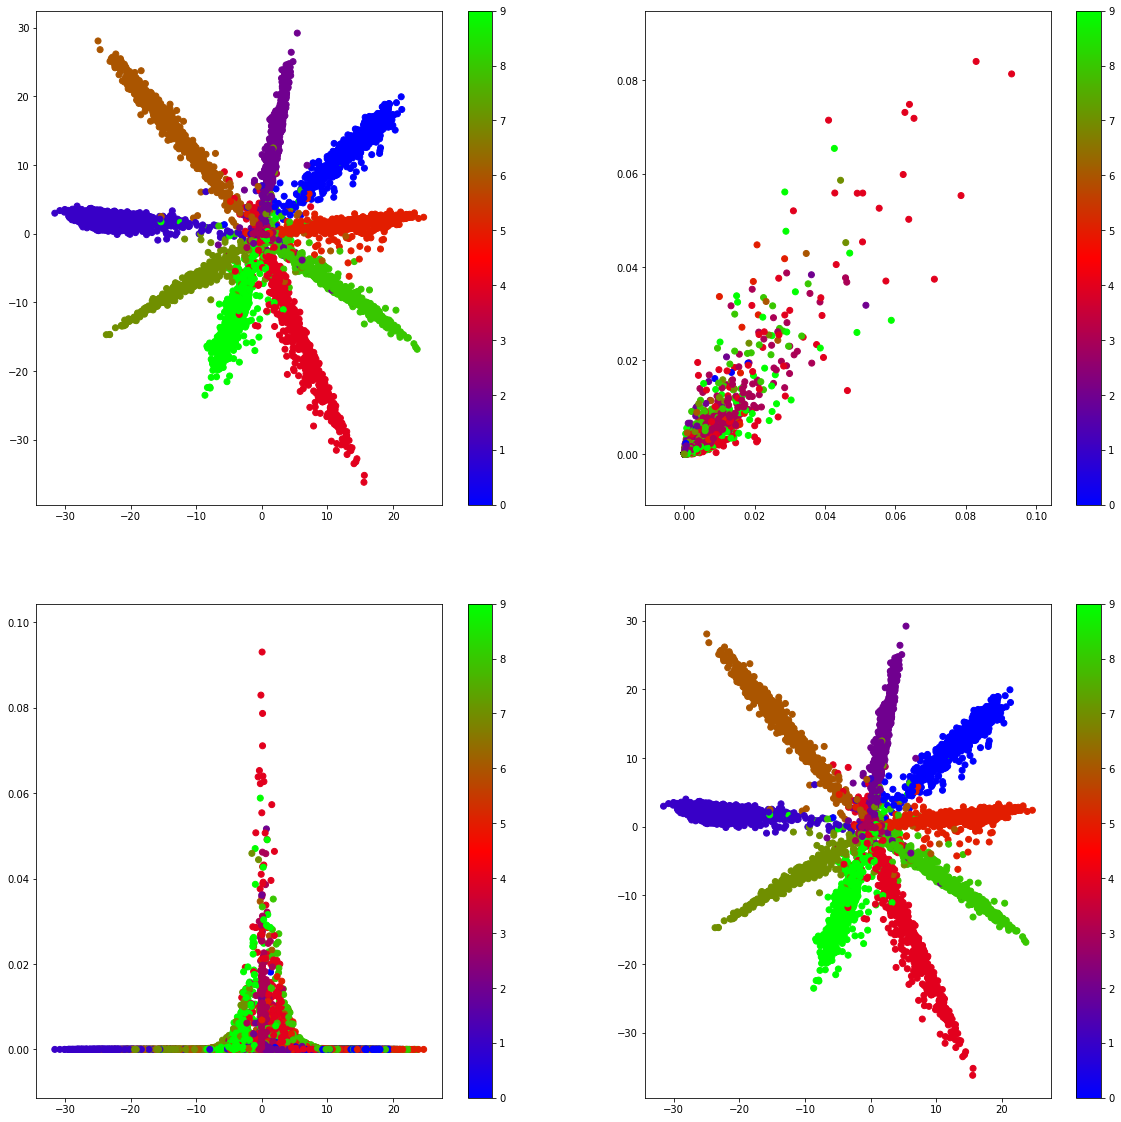

In [85]:
plot_2d_latent_space(model_supervised, onehot_encoder, X_test, y_test)

In [340]:
resp_train = model_supervised.encode_to_discrete(X_train)
resp_test = model_supervised.encode_to_discrete(X_test)

In [372]:
resp_train.shape, resp_test.shape, X_train.shape

((63000, 10), (7000, 10), (63000, 784))

In [459]:
latent_train = model_supervised.sampleLatent(X_train)
latent_test = model_supervised.sampleLatent(X_test)

In [460]:
latent_train.shape

(63000, 2)

In [461]:
class SimpleNN:
    
    def __init__(self, dims):
        self.dims = dims
        self.batch_size = 64
        
        self.x = tf.placeholder(tf.float32, [None, dims[0]])
        self.y_true = tf.placeholder(tf.float32, [None, 10])

#         l1 = DenseLayer(dims[0], dims[1])
#         l2 = DenseLayer(dims[1], 10, f=lambda x: x)
#         tmp = l1.forward(self.x)
#         y_pred = l2.forward(tmp)
        
        layers = []

        in_dim = dims.pop(0)
        for h_dim in dims:
            h = DenseLayer(in_dim, h_dim)
            layers.append(h)
            in_dim = h_dim

        current_value = self.x
        for layer in layers:
            current_value = layer.forward(current_value)
        
        y_pred = current_value

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=self.y_true))
#         self.gd_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
        self.gd_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cross_entropy)
        
        correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(self.y_true, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))
    
    def fit(self, train_input, train_output, test_input, test_output, epochs=10):
        
        n_batches = len(train_input) // self.batch_size
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(epochs):
                for j in range(n_batches):
                    batch_x = train_input[j * self.batch_size:(j + 1) * self.batch_size]
                    batch_y = train_output[j * self.batch_size:(j + 1) * self.batch_size]
                    sess.run(self.gd_step, feed_dict={self.x: batch_x, self.y_true: batch_y})

            train_accuracy = sess.run(self.accuracy, feed_dict={self.x: train_input, self.y_true: train_output})
            test_accuracy = sess.run(self.accuracy, feed_dict={self.x: test_input, self.y_true: test_output})
            print("Train accuracy: {:.4}%".format(train_accuracy*100))
            print("Test accuracy: {:.4}%".format(test_accuracy*100))

In [462]:
# simple_nn = SimpleNN([784,512,10])
# simple_nn.fit(X_train, y_train, X_test, y_test)

In [468]:
simple_nn = SimpleNN([10,512, 256, 128, 10])
simple_nn.fit(resp_train, y_train, resp_test, y_test, epochs=10)

Train accuracy: 86.57%
Test accuracy: 85.49%


In [466]:
simple_nn = SimpleNN([2,512, 256, 128, 10])
simple_nn.fit(latent_train, y_train, latent_test, y_test, epochs=10)

Train accuracy: 66.89%
Test accuracy: 66.24%


In [405]:
resp_train.shape

(63000, 10)

In [403]:
np.isnan(resp_train).sum(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [410]:
np.argwhere(np.isnan(resp_train))

array([], shape=(0, 2), dtype=int64)

In [409]:
resp_train[34097,:] = np.zeros(10)
resp_train[40214,:] = np.zeros(10)

In [414]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(resp_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [417]:
rf_predict = clf.predict(resp_test)

In [418]:
calculate_accuracy_np(y_pred=rf_predict, y_true=y_test)

0.6604285714285715

In [ ]:
np.argmax(resp_train, axis=1)

In [352]:
np.argmax(y_train, axis=1)

array([9, 1, 3, ..., 3, 1, 2])

In [354]:
reduced_data = pd.DataFrame({
    'in': np.argmax(resp_train, axis=1),
    'out': np.argmax(y_train, axis=1)
})

In [368]:
aaa = reduced_data[reduced_data['in']==6]

In [369]:
aaa.groupby(['out']).count()

,in
out,
1,1
2,3
3,13
4,468
5,12
6,6
7,50
8,22
9,5912


In [419]:
a = np.array([1,2,3,4])

In [420]:
a[]

4